In [1]:
!pip install transformers


     |████████████████████████████████| 1.8MB 8.3MB/s 
     |████████████████████████████████| 890kB 37.0MB/s 
     |████████████████████████████████| 3.2MB 54.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=07ccca9f3d5766b9aa02cb29222b292395b99363f8ab906101a8f3db92cca620
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
!pip install -q tf-models-official==2.3.0
import json

     |████████████████████████████████| 849kB 9.2MB/s 
     |████████████████████████████████| 37.6MB 83kB/s 
     |████████████████████████████████| 706kB 59.9MB/s 
     |████████████████████████████████| 1.2MB 59.0MB/s 
     |████████████████████████████████| 174kB 66.3MB/s 
     |████████████████████████████████| 358kB 64.0MB/s 
     |████████████████████████████████| 102kB 12.7MB/s 


In [3]:
with open("training.en-en.data", "r",encoding='UTF-8') as read_file:
    data = json.load(read_file)
with open("training.en-en.gold", "r",encoding='UTF-8') as read_file:
    gold = json.load(read_file)
with open("dev.en-en.data", "r",encoding='UTF-8') as read_file:
    dev_data = json.load(read_file)
with open("dev.en-en.gold", "r",encoding='UTF-8') as read_file:
    dev_gold = json.load(read_file)
with open("test.en-en.data", "r",encoding='UTF-8') as read_file:
    test_data = json.load(read_file)
with open("test.en-en.gold", "r",encoding='UTF-8') as read_file:
    test_gold = json.load(read_file)
with open("translated_en1_all.txt", "r",encoding='UTF-8') as read_file:
    para_sents1=read_file.readlines()
with open("translated_en2_all.txt", "r",encoding='UTF-8') as read_file:
    para_sents2=read_file.readlines()  
with open("translated-en_val1_all.txt", "r",encoding='UTF-8') as read_file:
    para_sents_val1=read_file.readlines()
with open("translated-en_val2_all.txt", "r",encoding='UTF-8') as read_file:
    para_sents_val2=read_file.readlines()  
with open("main_train2.txt", "r",encoding='UTF-8') as read_file:
    main_train2=read_file.readlines()
with open("main_train1.txt", "r",encoding='UTF-8') as read_file:
    main_train1=read_file.readlines()
with open("main_val2.txt", "r",encoding='UTF-8') as read_file:
    main_val2=read_file.readlines()
with open("main_val1.txt", "r",encoding='UTF-8') as read_file:
    main_val1=read_file.readlines()
with open("translated-en1_test_all.txt", "r",encoding='UTF-8') as read_file:
    para_sents_test1=read_file.readlines()
with open("translated_en2_test_all.txt", "r",encoding='UTF-8') as read_file:
    para_sents_test2=read_file.readlines()  
with open("main_test2.txt", "r",encoding='UTF-8') as read_file:
    main_test2=read_file.readlines()
with open("main_test1.txt", "r",encoding='UTF-8') as read_file:
    main_test1=read_file.readlines()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
from official.modeling import tf_utils
from official import nlp
from official.nlp import bert
from sklearn.model_selection import train_test_split
import json
# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks
import pandas as pd
import transformers as ppb
from nltk.corpus import wordnet

hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

# model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
# tokenizer =tokenizer_class.from_pretrained(pretrained_weights)
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))
def merge(lst1, lst2):
    return [a + b[1:] for (a, b) in zip(lst1, lst2)]

def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)
# df = pd.DataFrame(columns = 'label',data=[dat['tag'] for dat in gold])



Vocab size: 30522


In [5]:
def prepare_paraphrases(main1, main2 ,para_sents1,para_sents2,data):
  sentences1=[]
  sentences2=[]
  paraphrased1=[]
  paraphrased2=[]
  for dat in data:
    sent1=dat['sentence1']
    sent2=dat['sentence2']
    sentences1.append(sent1)
    sentences2.append(sent2)
  count=0
  for sent in sentences1:
    sent1=sent+'\n'
    if sent in main1:
      ind=main1.index(sent)
      para=para_sents1[ind]
      paraphrased1.append(para[0:len(para)-1])
      count+=1
    elif sent1 in main1:
      ind=main1.index(sent1)
      para=para_sents1[ind]
      paraphrased1.append(para[0:len(para)-1])
      count+=1
    else:
      print(sent)
    # if count<5:
    #   print(ind)
    #   print(sent)
    #   print(para)
  print("countSents1:{}".format(count))
  count=0
  for sent in sentences2:
    sent2=sent+'\n'
    if sent in main2:
      ind=main2.index(sent)
      para=para_sents2[ind]
      paraphrased2.append(para[0:len(para)-1])
      count+=1
    elif sent2 in main2:
      ind=main2.index(sent2)
      para=para_sents2[ind]
      paraphrased2.append(para[0:len(para)-1])
      count+=1
    else:
      print(sent)
  print("countSents2:{}".format(count))
  return paraphrased1,paraphrased2


In [6]:
paraphrased1,paraphrased2=prepare_paraphrases(main_train1,main_train2,para_sents1,para_sents2,data)

countSents1:8000
countSents2:8000


In [7]:
paraphrases_val1,paraphrased_val2=prepare_paraphrases(main_val1,main_val2,para_sents_val1,para_sents_val2,dev_data)

countSents1:1000
countSents2:1000


In [8]:
paraphrases_test1,paraphrased_test2=prepare_paraphrases(main_test1,main_test2,para_sents_test1,para_sents_test2,test_data)

countSents1:1000
countSents2:1000


In [ ]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

In [9]:
labels_tmp= np.array([dat['tag'] for dat in gold])
labels= [0 if x=='F' else 1 for x in labels_tmp]
labels=np.asarray(labels)

In [10]:
labels_tmp_val= np.array([dat['tag'] for dat in dev_gold])
labels_val= [0 if x=='F' else 1 for x in labels_tmp_val]
labels_val=np.asarray(labels_val)

In [11]:
labels_tmp_test= np.array([dat['tag'] for dat in test_gold])
labels_test= [0 if x=='F' else 1 for x in labels_tmp_test]
labels_test=np.asarray(labels_test)

In [12]:
def prepareData(data, paraphrased1,paraphrased2):
    sentence1=[]
    sentence2=[]
    paraphrased1_encode=[]
    paraphrased2_encode=[]
    for i in range(len(data)):
        dat=data[i]
        para1=paraphrased1[i]
        para2=paraphrased2[i]
        sent1=dat['sentence1']
        sent2=dat['sentence2']
        
        wordInFirst=sent1[int(dat['start1']):int(dat['end1'])]
        wordInSecond=sent2[int(dat['start2']):int(dat['end2'])]
        newSent1=sent1[0:int(dat['start1'])]+'[TGT] '+wordInFirst+' [TGT]'+sent1[int(dat['end1']):len(sent1)]
        newSent2=sent2[0:int(dat['start2'])]+'[TGT] '+ wordInSecond+' [TGT]'+sent2[int(dat['end2']):len(sent2)]
        
        paraphrased1_encode.append(encode_sentence(para1))
        paraphrased2_encode.append(encode_sentence(para2))
        
        sentence1.append(encode_sentence(newSent1))
        sentence2.append(encode_sentence(newSent2))

    return sentence1,sentence2 , paraphrased1_encode, paraphrased2_encode

In [13]:
sentence1_train,sentence2_train, paraphrased1_train, paraphrased2_train=prepareData(data,paraphrased1,paraphrased2)

In [14]:
sentence1_val,sentence2_val, paraphrased1_val, paraphrased2_val=prepareData(dev_data,paraphrases_val1,paraphrased_val2)

In [15]:
sentence1_test,sentence2_test, paraphrased1_test, paraphrased2_test=prepareData(test_data,paraphrases_test1,paraphrased_test2)

In [16]:
def prepare_input(sentence1,sentence2,paraphrased1,paraphrased2):
    sentence1=tf.ragged.constant(sentence1)
    sentence2=tf.ragged.constant(sentence2)

    cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])] * sentence1.shape[0]
    input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)
    input_mask = tf.ones_like(input_word_ids).to_tensor()
    type_cls = tf.zeros_like(cls)
    type_s1 = tf.ones_like(sentence1)
    type_s2 = tf.ones_like(sentence2)
    type_s2 = type_s2+1;
    input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor()
    

    paraphrased1=tf.ragged.constant(paraphrased1)
    paraphrased2=tf.ragged.constant(paraphrased2)
    cls2 = [tokenizer.convert_tokens_to_ids(['[CLS]'])] * paraphrased1.shape[0]
    input_para_ids = tf.concat([cls2, paraphrased1, paraphrased2], axis=-1)
    input_mask_para = tf.ones_like(input_para_ids).to_tensor()
    type_cls2 = tf.zeros_like(cls2)
    type_para1 = tf.ones_like(paraphrased1)
    type_para2 = tf.ones_like(paraphrased2)
    type_para2 = type_para2+1;
    para_type_ids = tf.concat([type_cls2, type_para1, type_para2], axis=-1).to_tensor()

    inputs = {
        'input_word_ids': input_word_ids.to_tensor(),
        'input_mask': input_mask,
        'input_type_ids': input_type_ids,
        'input_para_ids':input_para_ids.to_tensor(),
        'input_mask_para':input_mask_para,
        'para_type_ids':para_type_ids}
    return inputs

In [18]:
inputs_train=prepare_input(sentence1_train,sentence2_train, paraphrased1_train, paraphrased2_train)

In [19]:
inputs_val=prepare_input(sentence1_val,sentence2_val, paraphrased1_val, paraphrased2_val)

In [20]:
inputs_test=prepare_input(sentence1_test,sentence2_test, paraphrased1_test, paraphrased2_test)

In [ ]:
max=0
max_type=[]
for i in range(input_word_ids.shape[0]):
  if input_word_ids[i].shape[0]>max:
    max=input_word_ids[i].shape[0]
    max_type=input_word_ids[i]
print(max_type[0:300])
   

In [ ]:
print(input_word_ids[2].shape)
print(input_type_ids[2].shape)
print(input_mask[2].shape)

(88,)
(236,)
(236,)


In [ ]:
inputs['input_word_ids'].shape

TensorShape([9000, None])

In [21]:

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())
bert_config = bert.configs.BertConfig.from_dict(config_dict)

print(config_dict)
# config_dict={'attention_probs_dropout_prob': 0.1,
#  'hidden_act': 'relu',
#  'hidden_dropout_prob': 0.1,
#  'hidden_size': 768,
#  'initializer_range': 0.02,
#  'intermediate_size': 3072,
#  'max_position_embeddings': 512,
#  'num_attention_heads': 12,
#  'num_hidden_layers': 12,
#  'type_vocab_size': 2,
#  'vocab_size': 30522}

# bert_config = bert.configs.BertConfig.from_dict(config_dict)

# print('test')
# print(bert_config['initializer_range'])
# print(bert.bert_models.get_transformer_encoder( bert_config ,sequence_length=100))

{'attention_probs_dropout_prob': 0.1, 'hidden_act': 'gelu', 'hidden_dropout_prob': 0.1, 'hidden_size': 768, 'initializer_range': 0.02, 'intermediate_size': 3072, 'max_position_embeddings': 512, 'num_attention_heads': 12, 'num_hidden_layers': 12, 'type_vocab_size': 2, 'vocab_size': 30522}


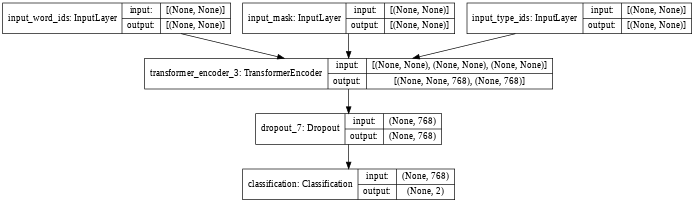

In [ ]:
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=48)

In [ ]:
del bert_classifier

In [ ]:
del bert_encoder

In [ ]:
del checkpoint

In [30]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(
    bert_config, num_labels=2)

checkpoint = tf.train.Checkpoint(model=bert_encoder)
checkpoint.restore(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()
# print(bert_encoder.get_embedding_table())
epochs = 10
batch_size = 32
eval_batch_size =32

train_data_size = len(labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min')
bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

bert_classifier.fit(
      inputs_train, labels,
      batch_size=32,
      validation_data=(inputs_val,labels_val),
      callbacks=[early_stopping],
      epochs=epochs)
export_dir='./saved_model'
tf.saved_model.save(bert_classifier, export_dir=export_dir)

INFO:absl:using Adamw optimizer
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['input_para_ids', 'input_mask_para', 'para_type_ids'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Epoch 1/10


250/250 [==============================] - 159s 598ms/step - loss: 0.6829 - accuracy: 0.5407 - val_loss: 0.4938 - val_accuracy: 0.7660
Epoch 2/10
250/250 [==============================] - 148s 593ms/step - loss: 0.4501 - accuracy: 0.8012 - val_loss: 0.3726 - val_accuracy: 0.8480
Epoch 3/10
250/250 [==============================] - 148s 593ms/step - loss: 0.2469 - accuracy: 0.9132 - val_loss: 0.4073 - val_accuracy: 0.8530
Epoch 4/10
250/250 [==============================] - 148s 593ms/step - loss: 0.1481 - accuracy: 0.9532 - val_loss: 0.5195 - val_accuracy: 0.8500


INFO:tensorflow:Assets written to: ./saved_model/assets


INFO:tensorflow:Assets written to: ./saved_model/assets


In [ ]:
bert_classifier_model = tf.keras.models.load_model('drive/MyDrive/saved_model/')


In [31]:
from sklearn.metrics import accuracy_score
result= bert_classifier.predict(inputs_test)
result = tf.argmax(result,axis=1).numpy()
# print(test_labels.shape)
print(accuracy_score(labels_test,result))
num=0
str=''
# for i in np.arange(0,1000,1):
#   if result[i]!=labels_test[i]:
#     num+=1
#     print('{}:trueLabel:{},resultLabel:{}'.format(i,labels_test[i],result[i]))

# print(num)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['input_para_ids', 'input_mask_para', 'para_type_ids'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


0.855


In [ ]:
# inputs_test=prepareData(test_data)
result= bert_classifier.predict(inputs_test)
result = tf.argmax(result,axis=1).numpy()
test_result = []
for i in range(len(result)):
  id="test.en-en.{}".format(i)
  test_result.append({
      'id':id,
      'tag':'T' if result[i]==1 else 'F'
  })
json_object = json.dumps(test_result, indent = 4) 
with open('test.en-en', 'w') as outfile:
    outfile.write(json_object) 